# CUNEF
### Trabajo de Final de Master 

# 03. Modelado y Análisis de resultados

In [1]:
# Importamos las librerias que van a ser utilizados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

import stellargraph as sg
from stellargraph.layer import GCN_LSTM

from sklearn.metrics import mean_squared_error,mean_absolute_error 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import  Model
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from keras.utils.vis_utils import plot_model

In [2]:
# Funcion definida para realizar la ventana de los datos con los que se van a trabajar

def sequence_data_preparation_predict(seq_len, pre_len, test_data_pred):
    testX_pred = []

    for i in range(test_data_pred.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data_pred[:, i : i + seq_len + pre_len]
        testX_pred.append(b[:, :seq_len])

    testX_pred = np.array(testX_pred)

    return testX_pred

def extract_metrics_from_predicted(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred).round(2)
    rmse = np.sqrt(mse).round(2)
    mae = mean_absolute_error(y_true, y_pred).round(2)
    mape =np.mean(np.abs((y_true - y_pred) / y_true)* 100).round(2)
    return (f'mse :{mse}, rmse: {rmse}, mae: {mae}, mape: {mape}')


### 1. Importamos los datos a trabajar

Se importan los datos tratados previamente en pasos anteriores

In [4]:
# Datos temporales sobre intensidad de tráfico
trainX=np.load('../datos/03_procesados/trainX.npy')
trainY=np.load('../datos/03_procesados/trainY.npy')
valX=np.load('../datos/03_procesados/valX.npy')
valY=np.load('../datos/03_procesados/valY.npy')
testX=np.load('../datos/03_procesados/testX.npy')
testY=np.load('../datos/03_procesados/testY.npy')
val_11=np.load('../datos/03_procesados/pred_11.npy')

test_scaled=np.load('../datos/03_procesados/test_scaled.npy')

# Datos Espaciales sobre la localización de sensores
matrix_lat_long = pickle.load(open('../datos/04_pickles/matrix_lat_long_final', 'rb'))

### 2. Creamos el modelo de Predicción

Aqui se crea la arquitectura del modelo de predicción utilizado en base a la información proporcionada por la librería StellarGraph

In [5]:
gcn_lstm = GCN_LSTM(
    seq_len=10,
    adj=matrix_lat_long,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200,200],
    lstm_activations=["tanh", "tanh"],
    dropout=0.1
)

C:\Users\karla\AppData\Local\Temp\ipykernel_26644\241442099.py:1: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  gcn_lstm = GCN_LSTM(


In [6]:
#Builds a GCN model for node  feature prediction
x_input, x_output = gcn_lstm.in_out_tensors()

model = Model(inputs=x_input, outputs=x_output)

In [7]:
# Seleccionamos el optimizador a utilizar y el ratio de aprendizaje
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mae", metrics=["mse"])

In [8]:
# Entrenamos el modelo creado con los datos de train y verificamos la funcion de perdida con los datos de validacion
history = model.fit(
    trainX,
    trainY,
    epochs=200,
    batch_size=60,
    shuffle=True,
    verbose=1,
    validation_data=(valX, valY),
)

model.summary()

Epoch 1/200
157/157 [==============================] - 26s 115ms/step - loss: 0.0732 - mse: 0.0161 - val_loss: 0.0448 - val_mse: 0.0042
Epoch 2/200
157/157 [==============================] - 17s 107ms/step - loss: 0.0439 - mse: 0.0042 - val_loss: 0.0434 - val_mse: 0.0039
Epoch 3/200
157/157 [==============================] - 16s 104ms/step - loss: 0.0306 - mse: 0.0024 - val_loss: 0.0165 - val_mse: 7.9641e-04
Epoch 4/200
157/157 [==============================] - 16s 102ms/step - loss: 0.0157 - mse: 7.1362e-04 - val_loss: 0.0133 - val_mse: 5.3719e-04
Epoch 5/200
157/157 [==============================] - 16s 100ms/step - loss: 0.0135 - mse: 5.5055e-04 - val_loss: 0.0126 - val_mse: 4.9595e-04
Epoch 6/200
157/157 [==============================] - 16s 100ms/step - loss: 0.0126 - mse: 4.9473e-04 - val_loss: 0.0123 - val_mse: 4.7187e-04
Epoch 7/200
157/157 [==============================] - 15s 98ms/step - loss: 0.0122 - mse: 4.7020e-04 - val_loss: 0.0121 - val_mse: 4.6032e-04
Epoch 8/200
1

Verificamos la arquitectura de la red neuronal realizada

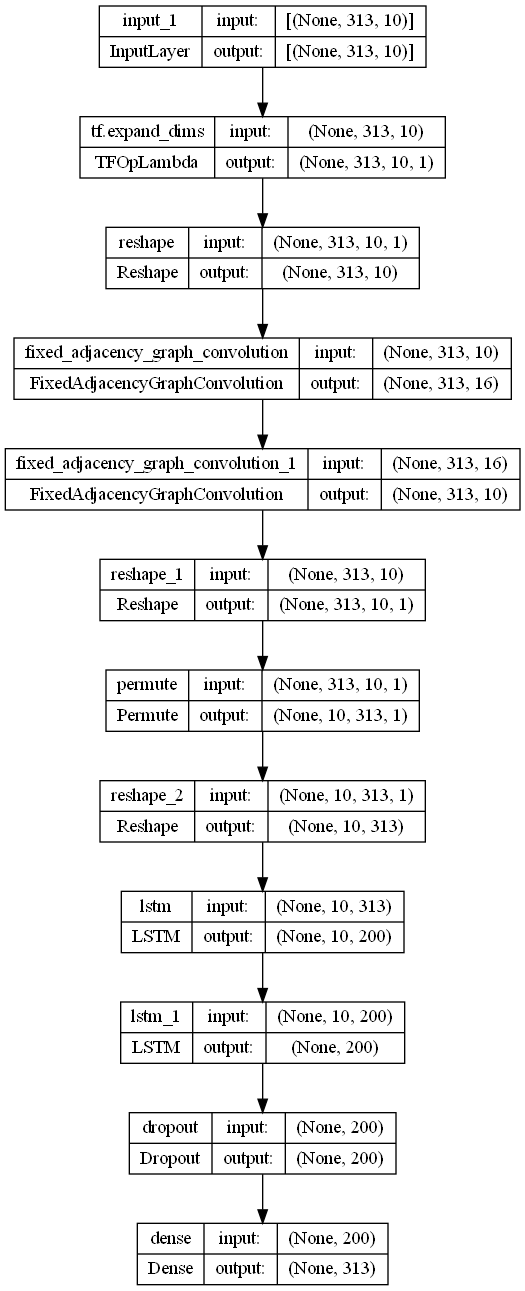

<Figure size 640x480 with 0 Axes>

In [9]:
plt.savefig('model_plot.png')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [10]:
print(
    "Train loss: ",
    history.history["loss"][-1]
)

Train loss:  0.008208534680306911


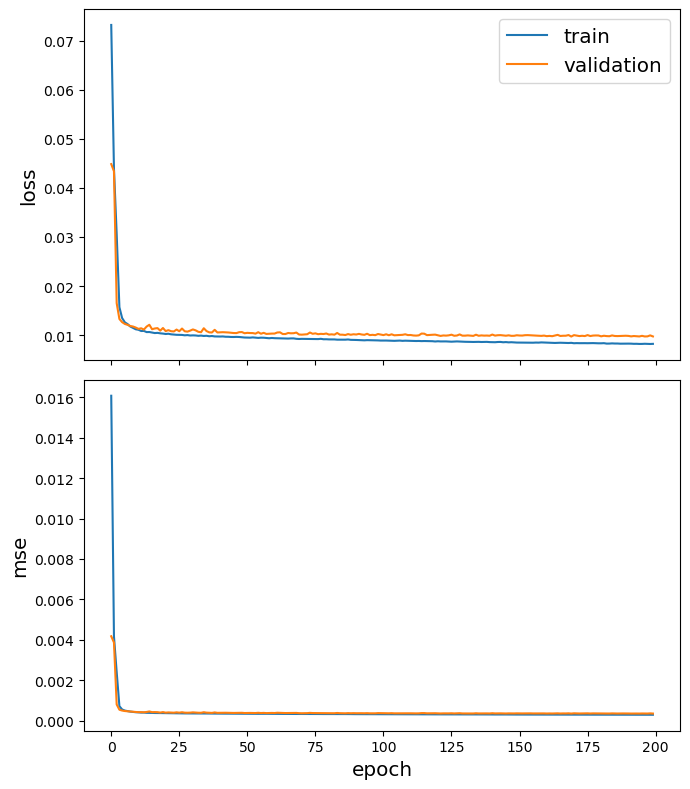

In [11]:
# Gráfico de función de pérdida
sg.utils.plot_history(history)

### 3.Creación de predicciones

Primera prediccion de valores

La primera prediccion se realiza tomando como entrada los 10 valores separados en el dataset de testX

In [12]:
# Realizamos la primera predicción del modelo

train_pred = model.predict(trainX)
pred_1= model.predict(testX)    

1/1 [==============================] - 0s 68ms/step


### Segunda prediccion de valores

Para la segunda predicción de 30 min tomamos el valor de la primera predicción realizada y agregamos a los datos de entrenamiento para con los 10 valores (9 valores pasados y 1 valor de la predicción 1) predecimos los siguientes 30 min

In [14]:
# Copiamos el dataset escalado original
test_data_2=test_scaled.copy()
test_data_2=pd.DataFrame(test_data_2)
val_10=test_data_2.iloc[:,-1] # nos quedamos con el valor 10 de la serie de textX
test_data_2=test_data_2.drop([0,10],axis=1)

# Introducimos el valor predicho anteriormente
list_pred=pd.DataFrame(pred_1)
test_data_2['pred_10']=list_pred.T
test_data_2['pred_data']=0

# Pasamos los datos a array, formato que trabaja el modelo
test_data_pred = np.array(test_data_2)

# Colocamos los datos con la ventana de observaciones con las que vamos a trabajar
testX_pred = sequence_data_preparation_predict(10, 1, test_data_pred)
testX_pred.shape

(1, 313, 10)

Realizamos la prediccion con un nuevo dataset de 10 valores

In [15]:
pred_2=  model.predict(testX_pred)

1/1 [==============================] - 0s 67ms/step


In [16]:
# La nueva predicción la guardamos como un dataframe
list_pred=pd.DataFrame(pred_2)

# Hacemos una copia del dataframe pasado y agregamos la segunda predicción realizada
df_pred=test_data_2.copy()
df_pred['pred_11']=list_pred.T


### 4. Viasualizamos valores reales y valores de resultado en las predicciones

In [17]:
# Insertamos los valores reales de las predicciones 1 y 2 al nuevo dataframe
df_pred[10]=val_10
df_pred[11]=val_11

# Ordenamos las columnas del nuevo dataframe
col_order=[1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,'pred_10','pred_11']
df_pred=df_pred[col_order]
df_pred

,1,2,3,4,5,6,7,8,9,10,11,pred_10,pred_11
0,0.036024,0.030145,0.036771,0.045450,0.055250,0.052823,0.033504,0.019785,0.016519,0.013532,0.017079,0.012191,0.012098
1,0.052543,0.046197,0.056370,0.067849,0.085114,0.060196,0.049837,0.034624,0.020065,0.013159,0.015026,0.020010,0.018176
2,0.040131,0.037611,0.035464,0.040411,0.055156,0.049463,0.047597,0.030611,0.022585,0.021652,0.025198,0.020207,0.019074
3,0.120299,0.114792,0.130845,0.136444,0.188707,0.152870,0.103780,0.055810,0.029865,0.029585,0.024732,0.039186,0.038513
4,0.055063,0.031731,0.008399,0.008399,0.059449,0.076435,0.069529,0.041811,0.027718,0.030798,0.035091,0.040309,0.034573
...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,0.095100,0.099020,0.081661,0.090714,0.104900,0.076528,0.057210,0.058703,0.049837,0.046477,0.034344,0.033002,0.031543
309,0.064302,0.060103,0.079515,0.087727,0.084834,0.078395,0.047037,0.028278,0.022399,0.022305,0.023985,0.017601,0.016378
310,0.013066,0.016799,0.009706,0.014932,0.023145,0.016426,0.013439,0.011386,0.008586,0.007746,0.009333,0.006227,0.006253
311,0.178628,0.186561,0.185814,0.202800,0.233038,0.165749,0.116939,0.073915,0.057956,0.042557,0.043677,0.052188,0.047238


Los valores normalizados los re-escalamos para trabajar con el rango inicial de intensidad de tráfico

In [18]:
# Identificamos valor minimo y máximo definido para el proceso de re-escalado
max_speed = 10715.0
min_speed= 0

# Reescalamos la tabla resultante de valores real vs predicciones
df_pred = df_pred * (max_speed - min_speed) + min_speed
df_pred

,1,2,3,4,5,6,7,8,9,10,11,pred_10,pred_11
0,386.0,323.0,394.0,487.0,592.0,566.0,359.0,212.0,177.0,145.0,183.0,130.625916,129.630966
1,563.0,495.0,604.0,727.0,912.0,645.0,534.0,371.0,215.0,141.0,161.0,214.408325,194.752945
2,430.0,403.0,380.0,433.0,591.0,530.0,510.0,328.0,242.0,232.0,270.0,216.516754,204.381851
3,1289.0,1230.0,1402.0,1462.0,2022.0,1638.0,1112.0,598.0,320.0,317.0,265.0,419.876801,412.664825
4,590.0,340.0,90.0,90.0,637.0,819.0,745.0,448.0,297.0,330.0,376.0,431.909119,370.449066
...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,1019.0,1061.0,875.0,972.0,1124.0,820.0,613.0,629.0,534.0,498.0,368.0,353.618347,337.981598
309,689.0,644.0,852.0,940.0,909.0,840.0,504.0,303.0,240.0,239.0,257.0,188.594101,175.489792
310,140.0,180.0,104.0,160.0,248.0,176.0,144.0,122.0,92.0,83.0,100.0,66.725838,66.997467
311,1914.0,1999.0,1991.0,2173.0,2497.0,1776.0,1253.0,792.0,621.0,456.0,468.0,559.189575,506.159119


### 5. Métricas de salida de valores predichos por red neuronal

In [19]:
# Seleccionamos las variables con las vamos a comparar las predicciones
y_true_0=df_pred.loc[:,10]
y_true_1=df_pred.loc[:,11]

y_pred_0=df_pred.loc[:,'pred_10']
y_pred_1=df_pred.loc[:,'pred_11']

In [20]:
print(f'Salida de la segunda prediccion {extract_metrics_from_predicted(y_true_0, y_pred_0)}')
print(f'Salida de la primera prediccion {extract_metrics_from_predicted(y_true_1, y_pred_1)}')

Salida de la segunda prediccion mse :12995.12, rmse: 114.0, mae: 66.38, mape: 23.6
Salida de la primera prediccion mse :16520.94, rmse: 128.53, mae: 70.26, mape: 24.15


### 6. Comparando el modelo de redes neuronales utilizando un modelo base

Creamos un modelo base el cual tome el valor anterior de la serie temporal com predicción

In [21]:
# Importamos todos los datos de intensidad de sensores
pred_speed_data=pd.read_csv("../datos/03_procesados/datos_procesados.csv", index_col='id')
pred_speed_data['-1']=pred_speed_data.iloc[:,0]

# Cambio el orden de las columnas para que el primer dato (columna -1) quede en la parte inicial del dataframe
cols = pred_speed_data.columns.tolist()
cols = cols[-1:] + cols[:-1]


base_model=pred_speed_data[cols].iloc[:,:-1]
base_model=base_model.reset_index()
b_m=base_model.drop(['id'], axis=1)
b_m

,-1,0,1,2,3,4,5,6,7,8,...,11749,11750,11751,11752,11753,11754,11755,11756,11757,11758
0,317.0,317.0,328.0,257.0,248.0,271.0,300.0,167.0,216.0,161.0,...,386.0,323.0,394.0,487.0,592.0,566.0,359.0,212.0,177.0,145.0
1,551.0,551.0,512.0,444.0,420.0,352.0,308.0,272.0,300.0,319.0,...,563.0,495.0,604.0,727.0,912.0,645.0,534.0,371.0,215.0,141.0
2,711.0,711.0,535.0,681.0,621.0,564.0,518.0,561.0,438.0,355.0,...,430.0,403.0,380.0,433.0,591.0,530.0,510.0,328.0,242.0,232.0
3,1297.0,1297.0,1359.0,1243.0,1119.0,933.0,897.0,893.0,660.0,616.0,...,1289.0,1230.0,1402.0,1462.0,2022.0,1638.0,1112.0,598.0,320.0,317.0
4,1226.0,1226.0,1128.0,908.0,776.0,649.0,444.0,486.0,380.0,318.0,...,590.0,340.0,90.0,90.0,637.0,819.0,745.0,448.0,297.0,330.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,1072.0,1072.0,1007.0,1017.0,920.0,728.0,670.0,597.0,524.0,518.0,...,1019.0,1061.0,875.0,972.0,1124.0,820.0,613.0,629.0,534.0,498.0
309,741.0,741.0,578.0,528.0,392.0,390.0,271.0,299.0,254.0,307.0,...,689.0,644.0,852.0,940.0,909.0,840.0,504.0,303.0,240.0,239.0
310,241.0,241.0,264.0,212.0,156.0,140.0,126.0,88.0,51.0,93.0,...,140.0,180.0,104.0,160.0,248.0,176.0,144.0,122.0,92.0,83.0
311,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,...,1914.0,1999.0,1991.0,2173.0,2497.0,1776.0,1253.0,792.0,621.0,456.0


In [22]:
bs_pred_0=b_m.iloc[:,-2]
bs_pred_1=b_m.iloc[:,-1]

In [23]:
print(f'Salida de la primera prediccion {extract_metrics_from_predicted(y_true_0, bs_pred_0)}')
print(f'Salida de la segunda prediccion {extract_metrics_from_predicted(y_true_1, bs_pred_1)}')

Salida de la primera prediccion mse :7980.57, rmse: 89.33, mae: 55.91, mape: 23.48
Salida de la segunda prediccion mse :4142.49, rmse: 64.36, mae: 38.04, mape: 18.05


## Visualización de comportamiento de modelos

Seran seleccionados un conjunto de sensores apra ver su comportamiento en relacion a los datos reales, el modelo base creado y el modelo T-GCN con ffin de evaluar su desempeño.

In [24]:
# Se seleccionan los IDs a evaluar
list_id=[4009, 4005, 4011, 4024, 3994, 10100]

Creamos los dataframes los que serán trabajados

In [25]:
# Importo los datos reales con los que vamos a trabajar
real_caso=pd.read_csv("../datos/03_procesados/datos_procesados.csv")
real_caso=real_caso[real_caso['id'].isin(list_id)].set_index(['id'])
real_caso=real_caso.iloc[:,10:9398]

# Coloco el modelo base con las condiciones para poder realizar la comparacion, seleccionando los sensores a evaluar
bm_caso=base_model[base_model['id'].isin(list_id)].set_index(['id'])
bm_caso=bm_caso.iloc[:,10:9398]

# Trabajamos los datos de la salida del modelo NN para realizar las comparaciones
max_speed = 10715
pre_model=pd.DataFrame(train_pred)

pre_model=(pre_model*max_speed).T #multiplicamos por el valor maximo de los datos del modelo y buscamos su transpuesta
pre_model['id']=base_model['id'] # Los datos no presentan el id del sensor, se busca para ingresarlos
pm_caso=pre_model[pre_model['id'].isin(list_id)]
pm_caso=pm_caso.set_index(['id'])

### Verificamos las gráficas de salida para cada modelo creado

Gráfico para sensor 4005 en posición 2 del dataframe

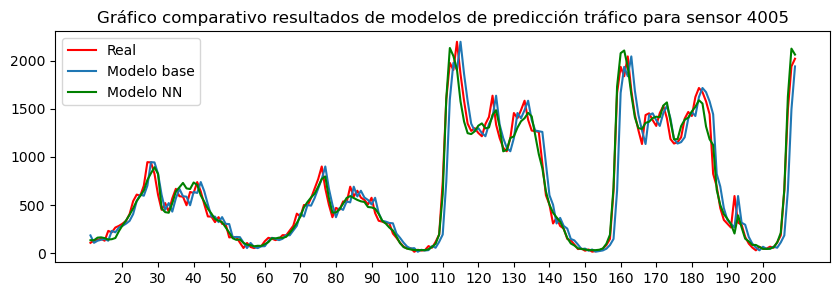

In [26]:
# Se selcciona el intervalo a analizar
indices = range(1, 200)

# Se crea el gráfico para los datos reales y la comparación con los modelos

plt.figure(figsize=(10, 3))
plt.plot(real_caso.columns[indices], real_caso.iloc[2, indices], color='red', label='Real')
plt.plot(real_caso.columns[indices], bm_caso.iloc[2, indices], label='Modelo base')
plt.plot(real_caso.columns[indices], pm_caso.iloc[2, indices], color='green', label='Modelo NN')

multiples_of_10 = np.arange(10, 200, 10)

plt.xticks(real_caso.columns[multiples_of_10])  # Establecer marcas solo en múltiplos de 10
plt.legend()
plt.title(f'Gráfico comparativo resultados de modelos de predicción tráfico para sensor 4005')
plt.show()

Gráfico para sensor 4009 en posición 3 del dataframe

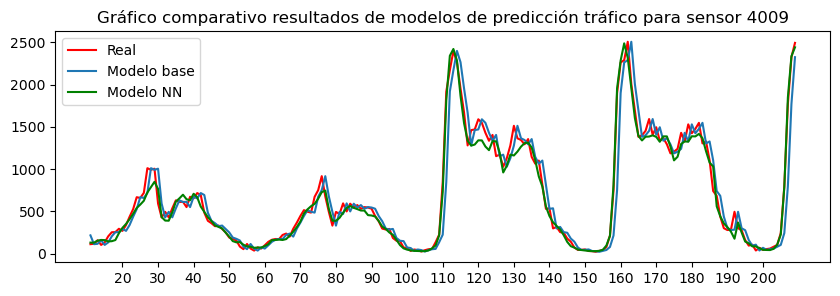

In [27]:
# Se selcciona el intervalo a analizar
indices = range(1, 200)

# Se crea el gráfico para los datos reales y la comparación con los modelos

plt.figure(figsize=(10, 3))
plt.plot(real_caso.columns[indices], real_caso.iloc[3, indices], color='red', label='Real')
plt.plot(real_caso.columns[indices], bm_caso.iloc[3, indices], label='Modelo base')
plt.plot(real_caso.columns[indices], pm_caso.iloc[3, indices], color='green', label='Modelo NN')

multiples_of_10 = np.arange(10, 200, 10)

plt.xticks(real_caso.columns[multiples_of_10])  # Establecer marcas solo en múltiplos de 10
plt.title(f'Gráfico comparativo resultados de modelos de predicción tráfico para sensor 4009')

plt.legend()
plt.show()

Gráfico para sensor 10100 en posición 5 del dataframe

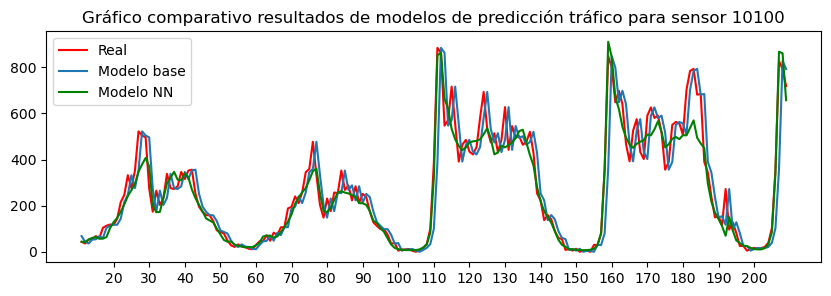

In [28]:
# Se selcciona el intervalo a analizar
indices = range(1, 200)

# Se crea el gráfico para los datos reales y la comparación con los modelos

plt.figure(figsize=(10, 3))
plt.plot(real_caso.columns[indices], real_caso.iloc[5, indices], color='red', label='Real')
plt.plot(real_caso.columns[indices], bm_caso.iloc[5, indices], label='Modelo base')
plt.plot(real_caso.columns[indices], pm_caso.iloc[5, indices], color='green', label='Modelo NN')

multiples_of_10 = np.arange(10, 200, 10)

plt.xticks(real_caso.columns[multiples_of_10])  # Establecer marcas solo en múltiplos de 10
plt.title(f'Gráfico comparativo resultados de modelos de predicción tráfico para sensor 10100')

plt.legend()
plt.show()